# ONC API 2.0 Usage
Python API usage

[`https://wiki.oceannetworks.ca/display/O2A/Python+Client+Library`](https://wiki.oceannetworks.ca/display/O2A/Python+Client+Library)

Timeseries parameters

[`https://wiki.oceannetworks.ca/display/DP/1`](https://wiki.oceannetworks.ca/display/DP/1)

ADCP parameters

[`https://wiki.oceannetworks.ca/display/DP/5`](https://wiki.oceannetworks.ca/display/DP/5)

***

Import libraries

In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os
import datetime
import subprocess
from onc.onc import ONC
from dateutil.parser import parse
from cmocean import cm

%matplotlib inline

***

## Basic setup

Invoke ONC using token

In [3]:
onc = ONC('76fc91e5-d4a4-40f9-87fc-2f6d2707fc5a')

Data path and date parameters

In [4]:
daterange = ['2018 Jan 1 00:00', '2018 Jan 2 00:00']
path = '/ocean/bmoorema/research/MEOPAR/analysis-ben/data/ONC'
filters_basic = {
    'dateFrom': parse(daterange[0]).isoformat() + '.000Z',
    'dateTo': parse(daterange[1]).isoformat() + '.000Z',
}

Main download routine

In [5]:
def download_ONC(filters, path, maxRetries=200):
    """Downloads ONC data to path using the onc.onc.ONC library and returns the complete file path
    """
    
    # Construct filename including simple datestrings
    dates = [parse(filters[key]).strftime('%Y%b%d') for key in ['dateFrom', 'dateTo']]
    filename = '_'.join(
        ['ONC', filters['deviceCategoryCode'], filters['locationCode'], *dates],
    ) + '.' + filters['extension']
    
    # Assign filepath to a temporary directory (couldn't find a way around this)
    filepath = os.path.join(path, 'temp', filename)
    
    # Get download data and URL
    downloadHandle = onc.orderDataProduct(
        filters=filters, maxRetries=maxRetries, downloadResultsOnly=True, includeMetadataFile=False,
    )
    
    # Download data from URL to filepath
    downloadResult = onc.downloadFile(downloadHandle['downloadResults'][0]['url'], filepath)
    
    # Move file and remove temporary directory
    msg = subprocess.call(['mv', filepath, path])
    msg = subprocess.call(['rm', '-r', os.path.join(path, 'temp')])
    
    return os.path.join(path, filename)

***

## ADCP data
Define ADCP download parameters

In [6]:
# dpo parameters from https://wiki.oceannetworks.ca/display/DP/5
filters_ADCP = {
    'deviceCategoryCode': 'ADCP150KHZ',
    'dataProductCode': 'RADCPTS',
    'extension': 'nc',
    'dpo_ensemblePeriod': 900,    # Default value
    'dpo_velocityBinmapping': 2,  # Default value
    'dpo_3beam': 'Off',           # Default value
    'dpo_corScreen': 64,          # Default value
    'dpo_errVelScreen': 2,        # Default value
    'dpo_falseTarScreen': 255,    # Default value
}
filters_ADCP.update(filters_basic)

ADCP plotting routine

In [7]:
def plot_ADCP(filepath, location):
    """
    """

    # Load ADCP data
    data = xr.open_dataset(filepath)
    date = data.time.values.astype('datetime64[s]').astype(datetime.datetime)

    # Make figure
    fig, axs = plt.subplots(1, 2, figsize=(17, 10))
    cax = fig.add_axes([0.92, 0.15, 0.01, 0.7])

    # Plot u and v fields
    for ax, vel in zip(axs, ['u', 'v']):
        c = ax.contourf(date, data.depth, data[vel].T, levels=np.arange(-1, 1.1, 0.05), cmap=cm.curl, extend='both')
        ax.set_ylim([290, 20])
        ax.set_title(f'ADCP {vel} velocity at ONC {location} node')

    # Colorbar
    fig.colorbar(c, cax=cax, label='[m/s]')
    plt.show()
    
    return fig, axs

***

### Central node ADCP
Download to netCDF

In [8]:
# Download central node ADCP data as .nc
filters_ADCP['locationCode'] = 'SCVIP'
filepath = download_ONC(filters_ADCP, path)

Request Id: 3115577
Estimated File Size: No estimated file size available.
  Running.
  Running... working on time range 1 of 1, for device deployment 1 of 1.................................................................................................................
  Running...100.00% of deployment 1 of 1 completed.
  download URL: http://data.oceannetworks.ca/api/dataProductDelivery?method=download&token=76fc91e5-d4a4-40f9-87fc-2f6d2707fc5a&dpRunId=8020950&index=1
  0 files (100.32 KB) downloaded
Actual Processing/Download Time: 0:4:5.48


Load netCDF and plot

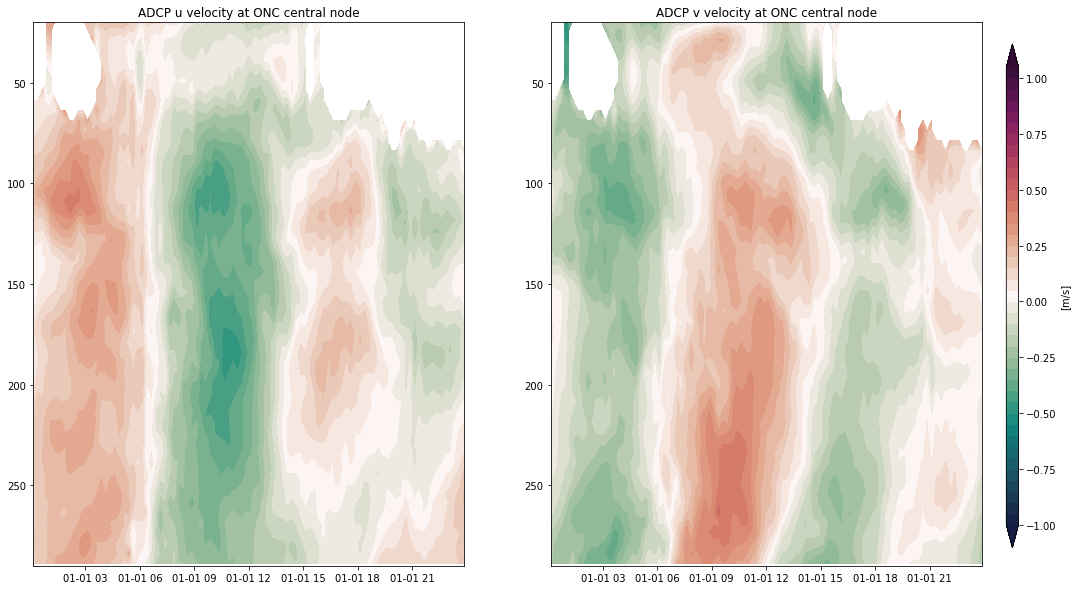

In [9]:
# Plot central node ADCP
fig, axs = plot_ADCP(filepath, 'central')

***

### East node ADCP
Download to netCDF

In [10]:
# Download east node ADCP data as .nc
filters_ADCP['locationCode'] = 'SEVIP'
filepath = download_ONC(filters_ADCP, path)

Request Id: 3115578
Estimated File Size: No estimated file size available.
  Running.
  Running... working on time range 1 of 1, for device deployment 1 of 1...............................................................................................
  download URL: http://data.oceannetworks.ca/api/dataProductDelivery?method=download&token=76fc91e5-d4a4-40f9-87fc-2f6d2707fc5a&dpRunId=8020951&index=1
  0 files (100.32 KB) downloaded
Actual Processing/Download Time: 0:3:24.75


Load netCDF and plot

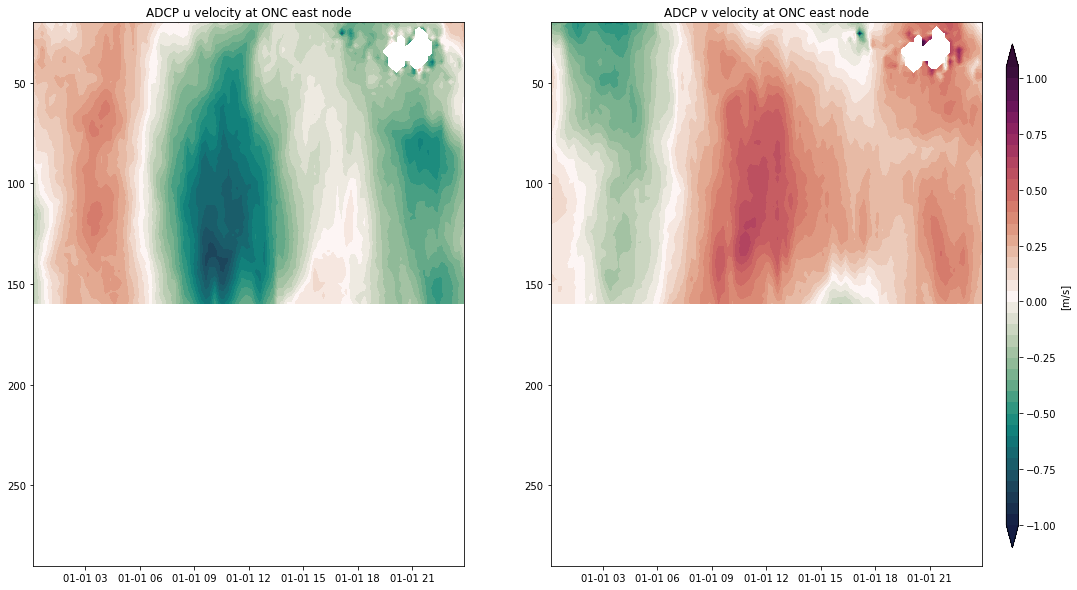

In [11]:
# Plot east node ADCP
fig, axs = plot_ADCP(filepath, 'east')

## Browsing
Look for locations with ADCP data

In [55]:
# Browse locations with ADCP data
for location in onc.getLocations({'dataProductCode': 'RADCPTS'}):
    print(location['locationCode'], location['locationName'])

/home/bmoorema/anaconda3/lib/python3.6/site-packages/requests/packages/urllib3/connectionpool.py:843: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


BACAX Axis 
BACME MidEast
BACMW MidWest
BACUS Upper Slope South
CBYIP Underwater Network
FGPD Folger Deep
FGPPN Folger Pinnacle
IOST NEPTUNE Testing
KEMF Main Endeavour Field
LSBBL Bottom Boundary Layer
LSDDL Delta Dynamics Laboratory
NC27 ODP 1026
NC89 Bullseye
NCBC Upper Slope
PBBL Bottom Boundary Layer
PVIP Saanich Inlet VENUS Instrument Platform
RCNE5 NE-250 mab
RCNW5 NW-250 mab
RCSE5.A1 ADCP Upward
RCSE5.A2 ADCP Downward
SCBBL Bottom Boundary Layer
SCVIP Strait of Georgia VENUS Instrument Platform
SEDDL Delta Dynamics Laboratory
SEVIP Strait of Georgia East VENUS Instrument Platform
SILL Saanich Inlet Sill
USDDL Delta Dynamics Laboratory
VEC CCGS Vector


Browse instruments at ADCP locations

In [56]:
# Browse instruments at locations with ADCP data
for location in onc.getLocations({'dataProductCode': 'RADCPTS'}):
    print(location['locationCode'], location['locationName'])
    for device in onc.getDeviceCategories({'locationCode': location['locationCode']}):
        print('     ' + device['deviceCategoryCode'])

/home/bmoorema/anaconda3/lib/python3.6/site-packages/requests/packages/urllib3/connectionpool.py:843: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


BACAX Axis 
     ADCP2MHZ
     ADCP55KHZ
     ADCP600KHZ
     ADCP75KHZ
     CAMLIGHTS
     CTD
     FLNTU
     HYDROPHONE
     IMGROTARYSONAR
     JB
     OXYSENSOR
     PTL
     SEDTRAP
     VIDEOCAM
BACME MidEast
     ADCP150KHZ
     ADCP2MHZ
     CAMLIGHTS
     CTD
     FLNTU
     IMGROTARYSONAR
     JB
     MBIOSENSOR
     MBPROFILESONAR
     OXYSENSOR
     PTL
     VIDEOCAM
BACMW MidWest
     ADCP150KHZ
     ADCP2MHZ
     IMGROTARYSONAR
     JB
     PLANKTONSAMPLER
     PTL
     SEDTRAP
     VIDEOCAM
BACUS Upper Slope South
     ADCP2MHZ
     ADCP600KHZ
     HYDROPHONE
     IMGROTARYSONAR
     JB
     PTL
     SEDTRAP
     TURBIDITYMETER
     VIDEOCAM
CBYIP Underwater Network
     ACOUSTICRECEIVER
     ADCP1200KHZ
     CAMLIGHTS
     CTD
     FLNTU
     HYDROPHONE
     ICEPROFILER
     NITRATESENSOR
     ORIENTATION
     OXYSENSOR
     PHSENSOR
     RADIOMETER
     VIDEOCAM
     WETLABS_WQM
FGPD Folger Deep
     ADCP300KHZ
     BPR
     CTD
     ECHOSOUNDERBIOA
     HYDROPHONE
  